In [92]:
from core.main_classes.domains import HyperParalelipiped
from core.main_classes.spaces import PCb, DirectSumSpace, RN
from core.aux.normal_data import load_normal_data
from core.main_classes.functions import *
from core.main_classes.mappings import *
from core.main_classes.SOLA_DLI import Problem
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set global parameters for matplotlib
plt.rcParams.update({'font.size': 15})  # Set default font size
plt.rcParams['axes.linewidth'] = 1.5  # Set the thickness of the axes lines


In [93]:
####################
# Create model space
####################
# Edit region -------------
physical_parameters = ['vs']

# Edit region -------------

physical_parameters_symbols = {'vs': '$\delta lnv_s$', 'vp': '$\delta lnv_p$', 'rho': '$\delta ln \\rho$'}
no_of_params = len(physical_parameters)
EarthDomain = HyperParalelipiped(bounds=[[0, 6371]], fineness=1000)
constituent_models_spaces = [PCb(domain=EarthDomain) for _ in physical_parameters]
# Create a dictionary with physical_parameters as keys
models_dict = {param: model_space for param, model_space in zip(physical_parameters, constituent_models_spaces)}
M = DirectSumSpace(tuple(constituent_models_spaces))

In [94]:
###################
# Create Data space
###################
# Edit region -------------
data_directory = '/disks/data/PhD/BGSOLA/BG_SOLA/normal_data/kernels_modeplotaat_Adrian'
which_data = list(np.arange(0, 143))
# Edit region -------------

# Import sensitivity data
how_many_data = len(which_data)
raw_sensitivity_dict = {}
raw_sensitivity_domains_dict = {}
for param in physical_parameters:
    raw_sensitivity_domain, raw_sensitivity = load_normal_data(param, data_directory)
    raw_sensitivity_dict[param] = np.array(raw_sensitivity)[which_data]
    if param not in raw_sensitivity_domains_dict:
        raw_sensitivity_domains_dict[param] = raw_sensitivity_domain
D = RN(dimension=how_many_data)

In [95]:
###########################
# Create model-data mapping 
###########################
# Make them into functions via interpolation
sensitivity_dict = {}
for param in physical_parameters:
    sensitivity_dict[param] = []
    for discrete_sensitivity_kernel in raw_sensitivity_dict[param]:
        sensitivity_dict[param].append(Interpolation_1D(values=discrete_sensitivity_kernel,
                                                        raw_domain=raw_sensitivity_domains_dict[param],
                                                        domain=EarthDomain))
constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=D, 
                                        kernels=sensitivity_dict[param]) for param in physical_parameters]
mappings_dict = {param: mapping for param, mapping in zip(physical_parameters, constituent_mappings)}
G = DirectSumMapping(domain=M, codomain=D, mappings=tuple(constituent_mappings))

In [96]:
###################################
# Create property mapping and space
###################################
# Edit region -------------
target_types = {'vs': Fourier}
orders = np.arange(0,20,1,dtype=int)
how_many_targets = 2*len(orders) - 1
# Edit region -------------
P = RN(dimension=how_many_targets)
targets_dict = {}
for param, target_type in target_types.items():
    targets_dict[param] = []
    for i in range(how_many_targets):
        if target_type == Fourier: # MODIFY HERE THE SPECIAL TARGET AS WELL!!!!
            if i == 0:
                target = target_type(domain=EarthDomain,type='cos', order=0)
            elif (i % 2 == 1):
                target = target_type(domain=EarthDomain,type='sin', order=int(i/2)+1)
            else:
                target = target_type(domain=EarthDomain,type='cos', order=i/2)
            targets_dict[param].append(target)
        else: 
            targets_dict[param].append(target_type(domain=EarthDomain))
constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=P, 
                                        kernels=targets_dict[param]) for param in physical_parameters]
T = DirectSumMapping(domain=M, codomain=P, mappings=tuple(constituent_mappings))

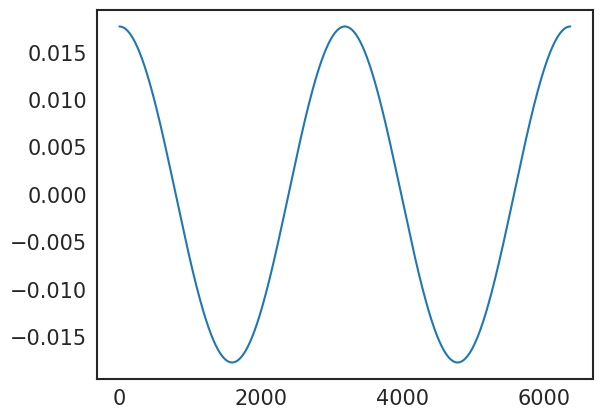

In [97]:
%matplotlib inline
plt.plot(EarthDomain.mesh, targets_dict[param][4].evaluate(EarthDomain.mesh)[1])
plt.show()

In [98]:
# Create color Palette
colors = sns.color_palette('YlGnBu', n_colors=100)

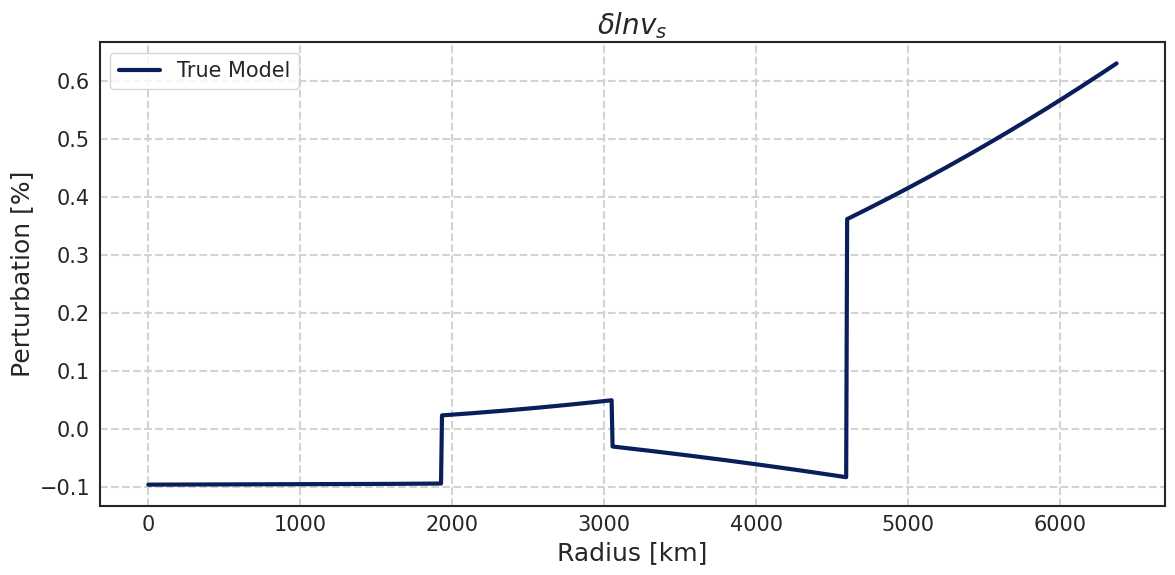

In [99]:

#################################
# Create fake true model and data
#################################
true_model = M.random_member(args_list=[(4,)])
data = G.map(true_model)

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))
for i, (submodel, physical_parameter) in enumerate(zip(true_model, physical_parameters)):
    axes.plot(EarthDomain.mesh, submodel.evaluate(EarthDomain.mesh)[1], 
            label='True Model', color=colors[99], linewidth=3)
    axes.set_title(physical_parameters_symbols[physical_parameter], fontsize=20)
    axes.set_xlabel('Radius [km]', fontsize=18)
    axes.set_ylabel('Perturbation [%]', fontsize=18)
    axes.tick_params(axis='both', which='major', labelsize=15)
    axes.legend(fontsize=15)
    axes.grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('truth.png', dpi=300, bbox_inches='tight')  # Save figure
plt.show()

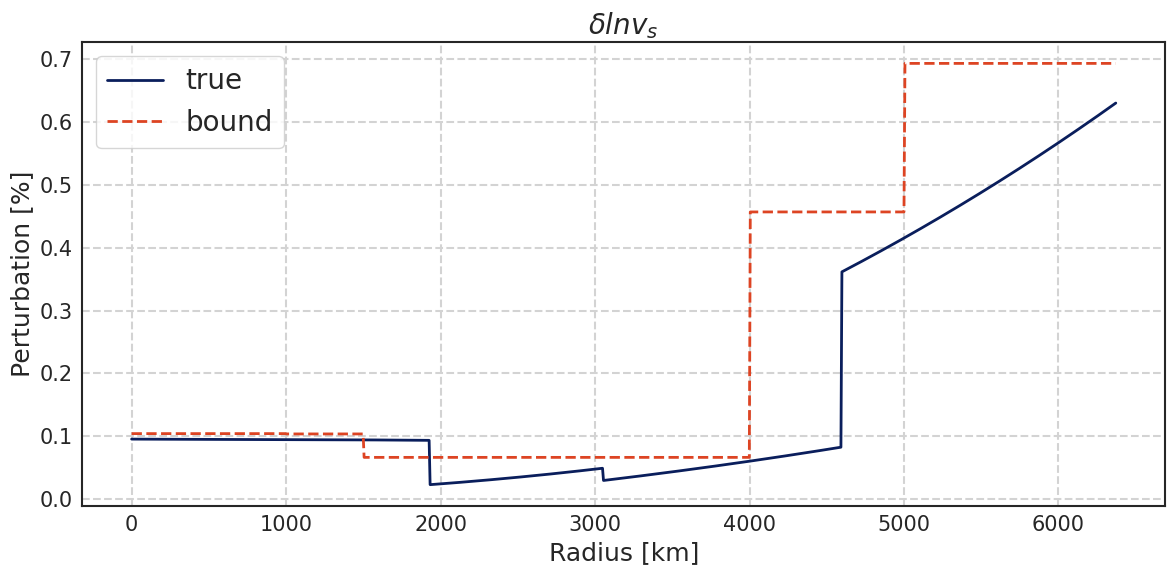

In [138]:
####################
# Compute norm bound
####################
# Edit region -------------
# Places where the true model will be evaluated
intervals = np.array([0,1000, 1500, 4000, 5000, EarthDomain.bounds[0][1]])
# Edit region -------------
upper_bounds = []
for model in true_model:
    values = np.abs(model.evaluate(intervals[1:])[1])*1.1
    upper_bound = Piecewise_1D(domain=model.domain,
                               intervals=intervals,
                               values=values)
    upper_bounds.append(upper_bound)
norm_bound = M.norm(tuple(upper_bounds))

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))

for i, (upperbound, submodel, physical_parameter) in enumerate(zip(upper_bounds, true_model, physical_parameters)):
    axes.plot(EarthDomain.mesh, np.abs(submodel.evaluate(EarthDomain.mesh)[1]), 
             label='true', color=colors[99], linewidth=2)
    axes.plot(EarthDomain.mesh, upperbound.evaluate(EarthDomain.mesh)[1], 
             label='bound', color='#dd4423', linestyle='--', linewidth=2)
    # Set title and labels
    axes.set_title(physical_parameters_symbols[physical_parameter], fontsize=20)
    axes.set_ylabel('Perturbation [%]', fontsize=18)
    # Set tick parameters
    axes.tick_params(axis='both', which='major', labelsize=15)
    # Add legend
    axes.legend(fontsize=12)
    axes.grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
    axes.legend(fontsize=20)
plt.xlabel('Radius [km]', fontsize=18)
plt.tight_layout()
plt.savefig('bound.png', bbox_inches='tight')
plt.show()

In [139]:
problem = Problem(M=M, D=D, P=P, G=G, T=T, norm_bound=norm_bound, data=data)

In [140]:
problem.solve()

In [141]:
problem._compute_least_norm_property()

In [142]:
# Compute True property
true_property = T.map(true_model)

In [143]:
# Compute fake inverse
aa = np.dot(problem.Gamma.matrix, problem.Gamma.matrix.T)
aa_inv = ImplicitInvFiniteLinearMapping(domain=P, codomain=P, inverse_matrix=aa)
pp = problem.Gamma.map(data)
sol = aa_inv.map(pp)

In [144]:
sol = np.linalg.lstsq(problem.Gamma.matrix.T, data)[0]


/tmp/ipykernel_905268/466452786.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol = np.linalg.lstsq(problem.Gamma.matrix.T, data)[0]


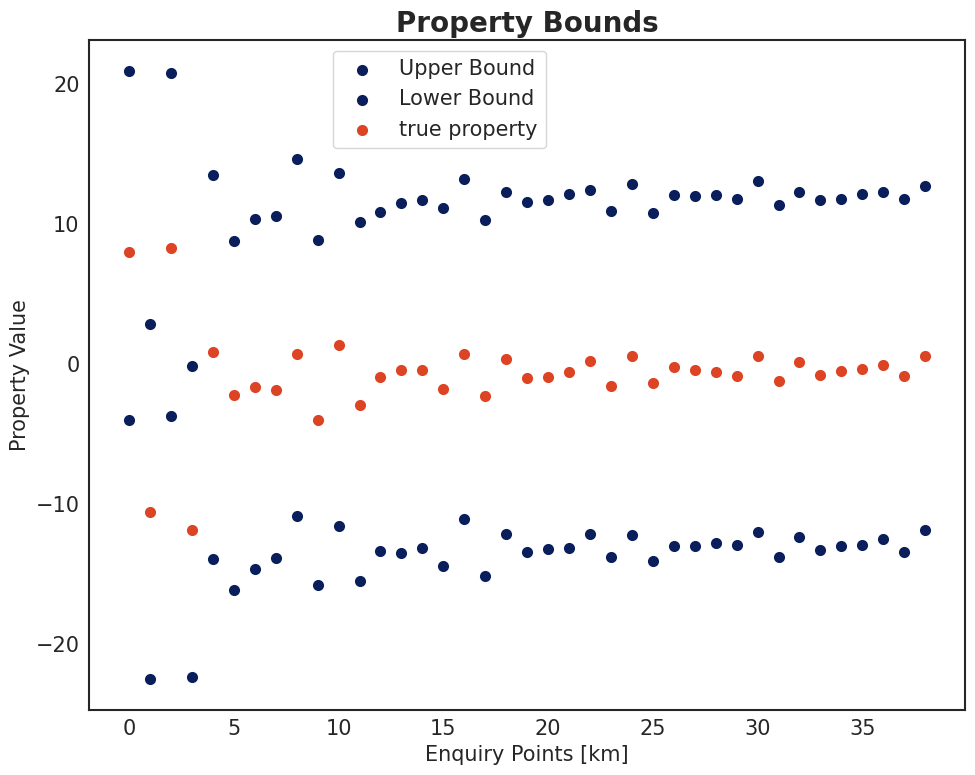

In [145]:
###############
# Plot solution
###############
# Find limits for y axis
y_max = np.max(true_property)*1.5
y_min = np.min(true_property)*1.5
enquiry_points = np.arange(0, how_many_targets)
# Plot the Solution section
plt.figure('Solution', figsize=(10, 8))
sns.set_style(style='white')  # Set seaborn style
plt.title('Property Bounds', fontsize=20, fontweight='bold')  # Increase font size and add bold
plt.scatter(enquiry_points, problem.solution['upper bound'], color=colors[99], 
         linewidth=2, label='Upper Bound')  # Increase line width
plt.scatter(enquiry_points, problem.solution['lower bound'], color=colors[99], 
         linewidth=2, label='Lower Bound')  # Increase line width and use dashed line
plt.scatter(enquiry_points, true_property, color='#dd4423', 
         linewidth=2, label='true property')
""" plt.scatter(enquiry_points, sol) """
#plt.ylim([y_min, y_max])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper center', bbox_to_anchor=(0.4, 1))

plt.xlabel('Enquiry Points [km]', fontsize=15)  # Add X-axis label with fontsize
plt.ylabel('Property Value', fontsize=15)  # Add Y-axis label with fontsize
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('new_solution.png', dpi=300, bbox_inches='tight')  # Increase resolution for high-quality output
plt.show()

In [146]:
my_sol = problem.T_adjoint.map(problem.least_norm_property)
other_sol = problem.T_adjoint.map(sol)

In [155]:
upper_bounds = problem.solution['upper bound']
lower_bounds = problem.solution['lower bound']
upper_bounds = [item for sublist in upper_bounds for item in sublist]
lower_bounds = [item for sublist in lower_bounds for item in sublist]

samples = []
for upper, lower in zip(upper_bounds, lower_bounds):
    sample = random.uniform(lower, upper)
    samples.append(sample)
samples = np.array(samples).reshape((len(samples), 1))
my_sol = problem.T_adjoint.map(samples)

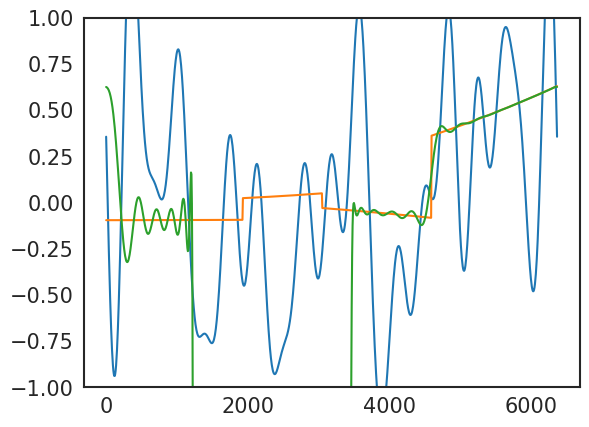

In [156]:

plt.plot(EarthDomain.mesh, my_sol[0].evaluate(EarthDomain.mesh)[1])
plt.plot(EarthDomain.mesh, true_model[0].evaluate(EarthDomain.mesh)[1])
plt.plot(EarthDomain.mesh, other_sol[0].evaluate(EarthDomain.mesh)[1])
plt.ylim([-1,1])
plt.show()